# importing libraries

In [1]:
import pandas as pd
import csv
import matplotlib.pyplot as plt
import numpy as np 
from ipykernel import kernelapp as app
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV, KFold,cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import optuna
import sklearn
from sklearn import datasets
from sklearn.svm import SVR
import optuna 
import shap
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import os
from new_plot import *
set_things()
set_font()


# Data loading and processing

In [2]:
path = r'/new_data3/'
prop ='ND'
propfile = path + prop +'.csv'
propcolumnname = prop
df = pd.read_csv(propfile)
a=df

In [3]:
old_col = df.columns.tolist()
new_col= {}
for c in old_col:
    new_col[c] = c + str(" [" + str(np.round(a[c].min(),2))+','+str(np.round(a[c].max(),2)) + "]")
df = df.rename(columns= new_col)

In [4]:
data = df.values

X_features = data[:,0:-1]
Y_properties = data[:,-1]

mean2 = Y_properties.mean()
#     scale = 10**int(np.log10(mean))
print("mean2 -> " + str(mean2))

# Y_properties /= mean2
# mean = Y_properties.mean()
# std = Y_properties.std()
# Zs = (Y_properties-mean)/std
# mask = (Zs<3) & (Zs>-3)

# X_features = X_features[mask.ravel(),:]
# Y_properties = Y_properties[mask].ravel()


sa = df.columns.values.tolist()
sa = list(sa[:-1])
a10 = sa

# X = pd.DataFrame(data = X_features,columns = a10)
# Y = pd.DataFrame(data = Y_properties, columns = [propcolumnname])

X_tr,X_shap,Y_tr,Y_shap = train_test_split(X_features,Y_properties,test_size=0.8, random_state=42)
X_train,X_test,Y_train,Y_test = train_test_split(X_features,Y_properties,test_size=0.2, random_state=33)


kfold = KFold(n_splits=4, shuffle=True,random_state=42)

mean2 -> 2.4428689736890297


# loading XGBoost params 

In [5]:

import pickle
file = 'data_new2/chalco_results2/'+ prop + '/'  + prop +'_XGB_new2.pickle' 
params  = None
if os.path.isfile(file):
    print(prop)
    with open(file,'rb') as f:
        df2 = pickle.load(f)
    params = df2[3]

ND


In [7]:
# defining booster 
if params['booster'] == 'dart':
    s = {'booster':'gbtree'}
    params.update(s)

# XGB training using optimum params

In [8]:
modelxg =  XGBRegressor(**params) 
modelxg.fit(X_train,Y_train)
scores2 = r2_score(modelxg.predict(X_train),Y_train)
scores2

[21:34:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "normalize_type", "rate_drop", "sample_type", "skip_drop" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




0.9826385013918205

# Shap analysis tree explainer 

In [10]:
# Shap analysis tree explainer 
explainer = shap.TreeExplainer(modelxg)
shap_values = explainer.shap_values(X_shap)
ivs = explainer.shap_interaction_values(X_shap)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [11]:
# saving shap and interaction values
import pickle
pickle.dump(shap_values, open('SHAP/Shap_values/' + prop+'_shapvalue.pkl','wb'))
pickle.dump(ivs, open('/Shap_values/' + prop+'_ivs.pkl','wb'))


In [12]:
des = list(pd.DataFrame(data=shap_values, columns=old_col[:-1]).abs().mean(axis=0).sort_values(ascending=False).index)

In [13]:
print(des)
# Saving interaction value labels in decreasing order of absolute value

['As', 'Te', 'S', 'Se', 'Sb', 'B', 'Tl', 'Ba', 'Ge', 'Ca', 'Al', 'Ga', 'Bi', 'P', 'Si', 'Pb', 'Na', 'In', 'Cu', 'Nb', 'Mg', 'K', 'Gd', 'Sn', 'La', 'Ti', 'Li', 'Zn', 'Sr', 'Ta', 'W', 'Y', 'Zr']


In [14]:
pickle.dump(des, open('SHAP/Shap_values/' + prop+'_des.pkl','wb'))

# SHAP summary plot: bar

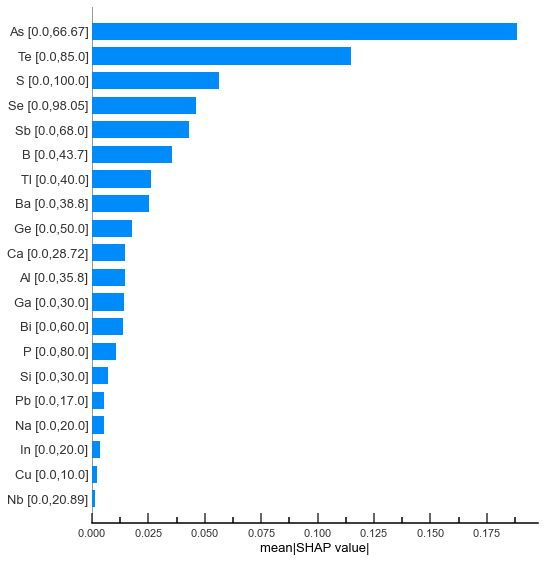

In [15]:
from new_plot import *
shap.initjs()
fig,ax = plt.subplots(figsize=(6,6))
shap.summary_plot(shap_values, X_shap,feature_names=a10,plot_type='bar',show=False)
plt.xlabel('mean|SHAP value|')#+propcolumnname)
#plt.savefig(prop+'bar_plot.png',dpi=1200,bbox_inches='tight')
plt.show()

# SHAP summary plot: violin¶

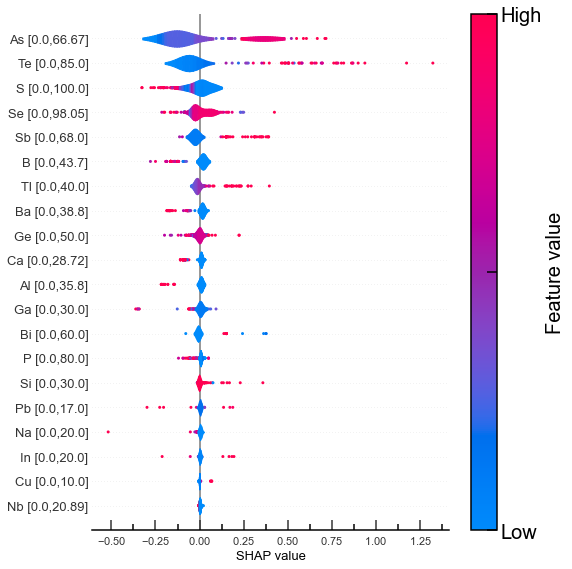

In [16]:
fig,ax = plt.subplots(figsize=(6,6))

shap.summary_plot(shap_values, X_shap ,feature_names= a10,plot_type='violin',show=False,
                 color_bar=False)
plt.xlabel('SHAP value')#+propcolumnname)
cbar = plt.colorbar()
cbar.set_label('Feature value')
cbar.minorticks_off()
#cbar.ax.set_axis_off()
midpoint_cbar = (cbar.vmax + cbar.vmin)/2
cbar.set_ticks([cbar.vmax,midpoint_cbar,cbar.vmin])#,labels=['High','Low'])
cbar.set_ticklabels(['High','','Low'])
plt.savefig(prop+'final_violin_plot.png',dpi=1200,bbox_inches='tight')
plt.show()

# SHAP riverflow plot

In [17]:
df_sv = pd.DataFrame(data = shap_values, columns=a10) 

#converting the column names into descending order of their mean abs sv
descending_order = list(df_sv.abs().mean(axis=0).sort_values(ascending=False).index)

#for river plot
river_sv = df_sv[descending_order[::-1]]
expected_value = explainer.expected_value

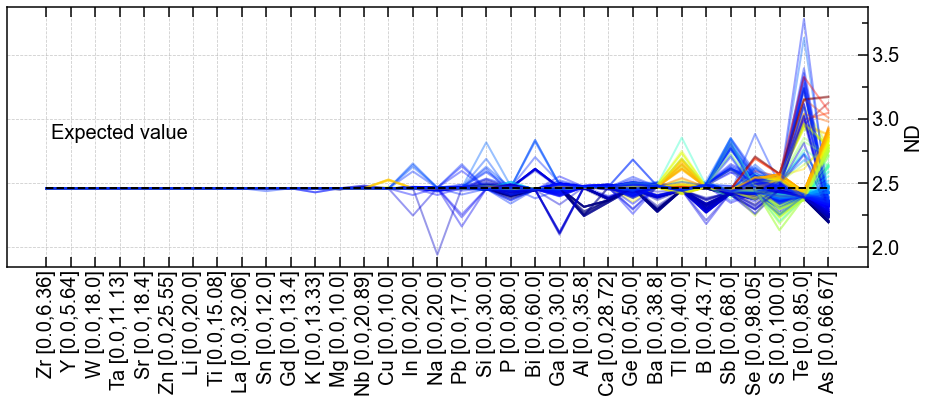

In [20]:
import matplotlib

fig,ax = plt.subplots(figsize=(13,6))

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='minor',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False)
ax.yaxis.set_ticks_position("right")
ax.yaxis.set_label_position("right")

cmap = matplotlib.cm.get_cmap('jet')
norm = matplotlib.colors.Normalize(vmin=np.min(river_sv.values[:,-1]), vmax=np.max(river_sv.values[:,-1]))
for i in range(len(river_sv)):
    plt.plot(river_sv.values[i].T+expected_value, alpha=0.4, c=cmap(norm(river_sv.values[i,-1])))
plt.plot([0,len(descending_order)-1],[expected_value,expected_value],'k--',linewidth=2.0)

plt.xticks(range(len(descending_order)), labels=list(descending_order[::-1]), size=20, rotation=90)
plt.tight_layout()
plt.text(0.2, expected_value+0.5, r'Expected value'%(expected_value), fontsize=20, fontweight='normal',va='top', ha='left')
plt.grid('on', color="gray", ls="--", which="major", alpha=0.4)
plt.ylabel(propcolumnname)
#plt.savefig('BulkModulus_riverflow.png',dpi=1200,bbox_inches='tight')
plt.show()
